### Credits

https://www.kaggle.com/nikitpatel/random-grid-bayes-search-cv-for-xgb

https://www.kaggle.com/shivamb/extensive-text-data-feature-engineering

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
# from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [2]:
from nltk.corpus import stopwords
stop_words = list(set(stopwords.words('english')))

### Basic EDA on text data

In [3]:
df = pd.read_csv("train.csv")

In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
question1 = np.array(df['question1'])
question2 = np.array(df['question2'])

text_df = pd.DataFrame(data=question1, columns=['question1'])
text_df['question2'] = question2

In [8]:
text_df['question2'][105780] = 'no text'
text_df['question2'][201841] = 'no text'

In [10]:
text_df['is_duplicate'] = df['is_duplicate']

In [11]:
text_df.fillna(value='no text', axis=1, inplace=True)

In [12]:
text_df['length of q1'] = text_df['question1'].apply(lambda x: len(x.split()))
text_df['length of q2'] = text_df['question2'].apply(lambda x: len(x.split()))

text_df['letter count of q1'] = text_df['question1'].apply(lambda x: len(x))
text_df['letter count of q2'] = text_df['question2'].apply(lambda x: len(x))

In [13]:
text_df['title_word_count_q1'] = text_df['question1'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
text_df['upper_case_word_count_q1'] = text_df['question1'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
text_df['title_word_count_q2'] = text_df['question2'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
text_df['upper_case_word_count_q2'] = text_df['question2'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [14]:
text_df['stopword_count_q1'] = text_df['question1'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))
text_df['stopword_count_q2'] = text_df['question2'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))

In [76]:
text_df.head()

,question1,question2,is_duplicate,length of q1,length of q2,letter count of q1,letter count of q2,title_word_count_q1,upper_case_word_count_q1,title_word_count_q2,upper_case_word_count_q2,stopword_count_q1,stopword_count_q2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14,12,66,57,1,0,1,0,7,6
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,8,13,51,88,3,0,3,0,4,4
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,14,10,73,59,2,2,2,1,8,5
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,11,9,50,65,4,2,1,0,7,4
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,13,7,76,39,1,0,1,0,3,2


In [15]:
plt_df = text_df.drop(labels=['question1', 'question2'], axis=1)

### plots

In [78]:
plt_df.head()

,is_duplicate,length of q1,length of q2,letter count of q1,letter count of q2,title_word_count_q1,upper_case_word_count_q1,title_word_count_q2,upper_case_word_count_q2,stopword_count_q1,stopword_count_q2
0,0,14,12,66,57,1,0,1,0,7,6
1,0,8,13,51,88,3,0,3,0,4,4
2,0,14,10,73,59,2,2,2,1,8,5
3,0,11,9,50,65,4,2,1,0,7,4
4,0,13,7,76,39,1,0,1,0,3,2


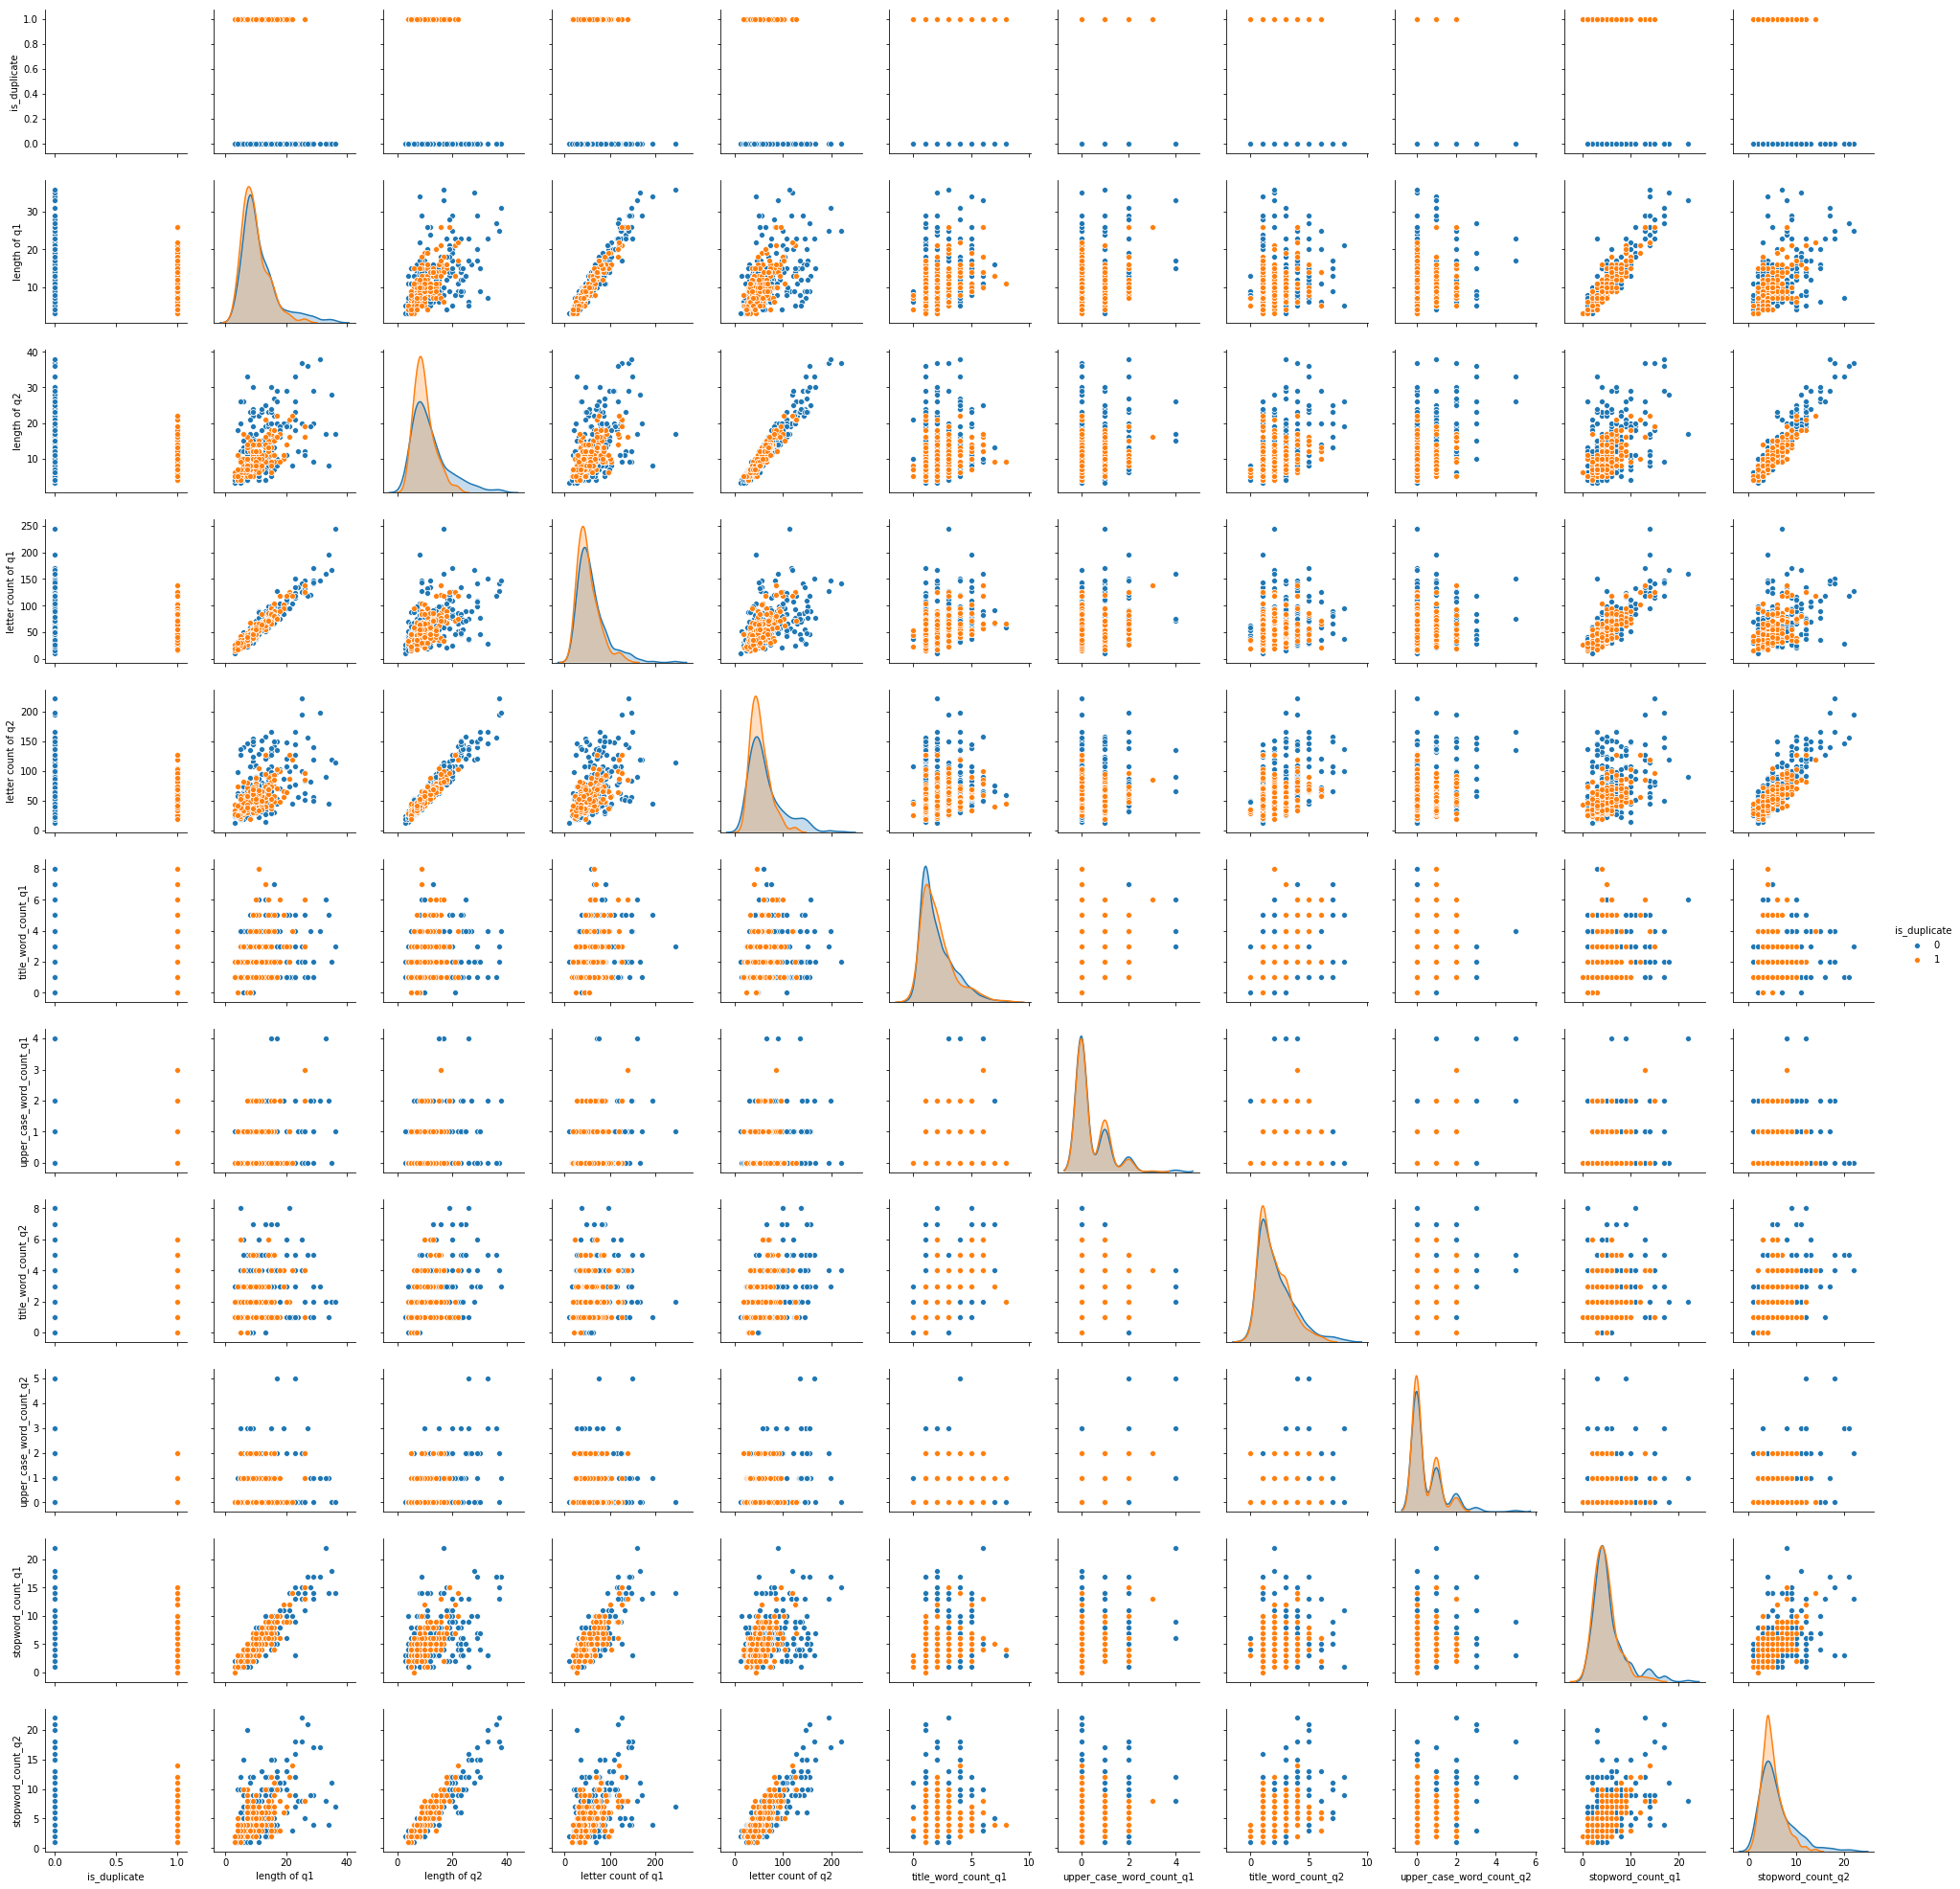

In [82]:
sns.pairplot(data=plt_df[:500], hue='is_duplicate', )

### Not much helpful, too much overlap

In [18]:
plt_df['word_density of q1'] = plt_df['letter count of q1']/ plt_df['length of q1']
plt_df['word_density of q2'] = plt_df['letter count of q2']/ plt_df['length of q2']

In [84]:
plt_df.head()

,is_duplicate,length of q1,length of q2,letter count of q1,letter count of q2,title_word_count_q1,upper_case_word_count_q1,title_word_count_q2,upper_case_word_count_q2,stopword_count_q1,stopword_count_q2,word_density of q1,word_density of q2
0,0,14,12,66,57,1,0,1,0,7,6,4.714286,4.750000
1,0,8,13,51,88,3,0,3,0,4,4,6.375000,6.769231
2,0,14,10,73,59,2,2,2,1,8,5,5.214286,5.900000
3,0,11,9,50,65,4,2,1,0,7,4,4.545455,7.222222
4,0,13,7,76,39,1,0,1,0,3,2,5.846154,5.571429


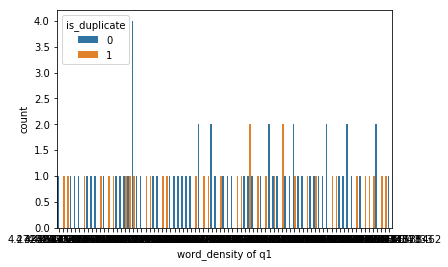

In [100]:
sns.countplot(x='word_density of q1', hue='is_duplicate', data=plt_df.sample(n=100))

In [87]:
plt_df.head()

,is_duplicate,length of q1,length of q2,letter count of q1,letter count of q2,title_word_count_q1,upper_case_word_count_q1,title_word_count_q2,upper_case_word_count_q2,stopword_count_q1,stopword_count_q2,word_density of q1,word_density of q2
0,0,14,12,66,57,1,0,1,0,7,6,4.714286,4.750000
1,0,8,13,51,88,3,0,3,0,4,4,6.375000,6.769231
2,0,14,10,73,59,2,2,2,1,8,5,5.214286,5.900000
3,0,11,9,50,65,4,2,1,0,7,4,4.545455,7.222222
4,0,13,7,76,39,1,0,1,0,3,2,5.846154,5.571429


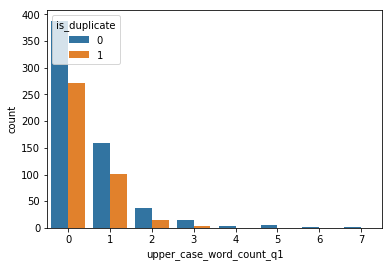

In [92]:
sns.countplot(x='upper_case_word_count_q1', hue='is_duplicate',data=plt_df.sample(n=1000))

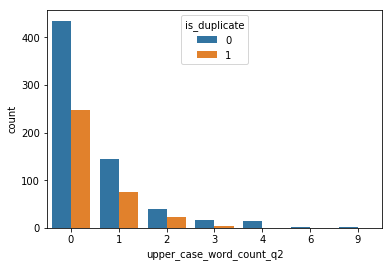

In [93]:
sns.countplot(x='upper_case_word_count_q2', hue='is_duplicate',data=plt_df.sample(n=1000))

### The above two features are helpful; Questions with lower number of upper case words in title are more likely to be duplicate. The lesser the upper case words, more its duplocate

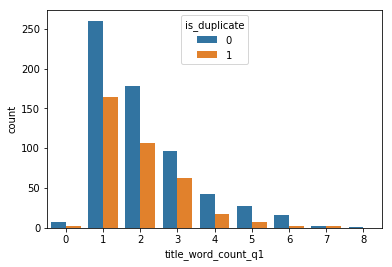

In [94]:
sns.countplot(x='title_word_count_q1', hue='is_duplicate', data=plt_df.sample(n=1000))

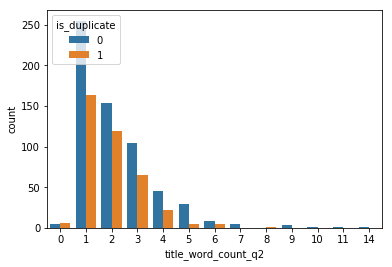

In [95]:
sns.countplot(x='title_word_count_q2', hue='is_duplicate', data=plt_df.sample(n=1000))

### Again an helpful feature.Questions with lower number of title words are more likely to be duplicate

In [102]:
plt_df.columns

Index(['is_duplicate', 'length of q1', 'length of q2', 'letter count of q1',
       'letter count of q2', 'title_word_count_q1', 'upper_case_word_count_q1',
       'title_word_count_q2', 'upper_case_word_count_q2', 'stopword_count_q1',
       'stopword_count_q2', 'word_density of q1', 'word_density of q2'],
      dtype='object')

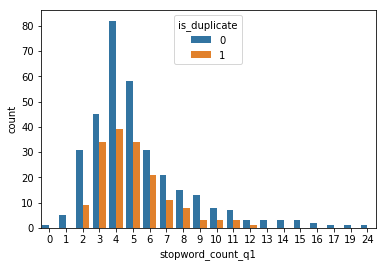

In [105]:
sns.countplot(x='stopword_count_q1', hue='is_duplicate', data=plt_df.sample(n=500))

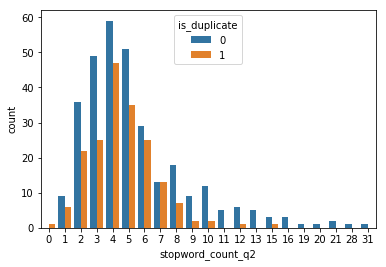

In [106]:
sns.countplot(x='stopword_count_q2', hue='is_duplicate', data=plt_df.sample(n=500))

### Another helpful feature; Stop word count is higher in duplicates than in real

In [107]:
plt_df.columns

Index(['is_duplicate', 'length of q1', 'length of q2', 'letter count of q1',
       'letter count of q2', 'title_word_count_q1', 'upper_case_word_count_q1',
       'title_word_count_q2', 'upper_case_word_count_q2', 'stopword_count_q1',
       'stopword_count_q2', 'word_density of q1', 'word_density of q2'],
      dtype='object')

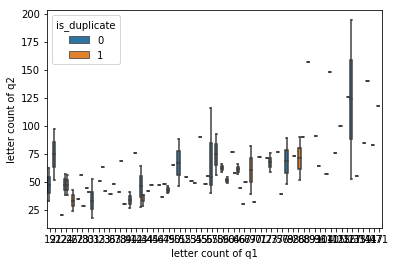

In [47]:
sns.boxplot(x='letter count of q1', y='letter count of q2', hue='is_duplicate', data=plt_df[:100])

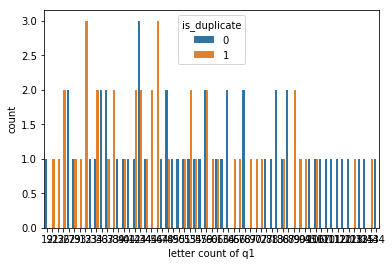

In [37]:
sns.countplot(x='letter count of q1', hue='is_duplicate', data=plt_df.sample(n=100))

#### nothing very helpful here too

In [41]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [42]:
freq_q1 = text_df['question1'].apply(lambda x: [wrd for wrd in x.split() if wrd.lower() not in stopwords])
freq_q2 = text_df['question2'].apply(lambda x: [wrd for wrd in x.split() if wrd.lower() not in stopwords])

In [43]:
newfreq1 = []
newfreq2 = []

for i in freq_q1:
    for j in i:
        newfreq1.append(j)

for i in freq_q2:
    for j in i:
        newfreq2.append(j)

In [44]:
from collections import Counter
freq_q1 = [i.split() for i in text_df['question1']]
freq_q2 = [i.split() for i in text_df['question2']]

In [54]:
wc_q1 = WordCloud().generate(str(newfreq1))
wc_q2 = WordCloud().generate(str(newfreq2))

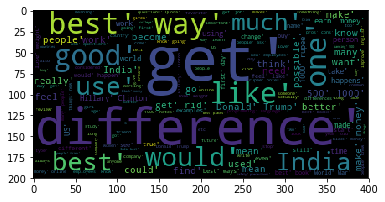

In [55]:
plt.imshow(wc_q1)

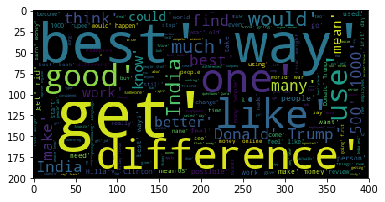

In [56]:
plt.imshow(wc_q2)

<h1> 3. Featurizing text data with tfidf weighted word-vectors </h1>

In [3]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Manually splitting the data

In [5]:
X_train = df[:283003]
X_test = df[283003:]

y_train = df['is_duplicate'][:283003]
y_test = df['is_duplicate'][283003:]

In [8]:
X_train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [9]:
X_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Tfidf Vectorization

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tfidf = TfidfVectorizer(min_df=10, max_features=5000, stop_words='english')
vect = tfidf.fit(X_train['question1'], X_train['question2'])

tfidf_train_qn1 = vect.transform(X_train['question1'])
tfidf_train_qn2 = vect.transform(X_train['question2'])

tfidf_test_qn1 = vect.transform(X_test['question1'])
tfidf_test_qn2 = vect.transform(X_test['question2'])

In [11]:
print(tfidf_train_qn1.shape)
print(tfidf_train_qn2.shape)
print(tfidf_test_qn1.shape)
print(tfidf_test_qn2.shape)

(283003, 5000)
(283003, 5000)
(121287, 5000)
(121287, 5000)


### dimensionality reduction

In [12]:
svd = TruncatedSVD(n_components=500)
tfidf_train_qn1_svd = svd.fit_transform(tfidf_train_qn1)
tfidf_train_qn2_svd = svd.fit_transform(tfidf_train_qn2)
tfidf_test_qn1_svd = svd.fit_transform(tfidf_test_qn1)
tfidf_test_qn2_svd = svd.fit_transform(tfidf_test_qn2)

In [13]:
df_train1 = pd.DataFrame(tfidf_train_qn1_svd, columns=[i for i in range(0,500)])

In [14]:
df_train2 = pd.DataFrame(tfidf_train_qn2_svd, columns=[i for i in range(0,500)])

In [15]:
train_tfidf = pd.concat([df_train1, df_train2], axis=1, ignore_index=True)

In [16]:
df_test1 = pd.DataFrame(data=tfidf_test_qn1_svd, columns = [i for i in range(0,500)])
df_test2 = pd.DataFrame(data= tfidf_test_qn2_svd, columns = [i for i in range(0,500)])

test_tfidf = pd.concat([df_test1, df_test2], axis = 1, ignore_index=True)

In [17]:
train_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.033245,0.013493,0.017777,-0.002288,0.035587,0.066957,0.145456,-0.046267,-0.040314,0.025407,...,0.004021,-0.007516,0.013232,0.010894,-0.022498,-0.051590,0.041018,0.007158,-0.008302,-0.062764
1,0.003586,0.002116,0.000419,0.000405,-0.000352,0.001315,-0.000132,0.003298,-0.000514,0.002005,...,-0.004531,0.002838,-0.005607,0.016391,-0.008521,-0.003823,0.002523,-0.003422,0.005964,0.005607
2,0.011968,0.010351,0.015090,-0.005784,0.007837,-0.003696,-0.001045,0.003935,-0.002284,-0.002157,...,-0.009573,-0.006236,-0.023627,-0.007919,-0.004713,-0.012403,-0.010114,0.040709,0.032461,-0.028205
3,0.001706,0.002544,0.002330,-0.000966,0.000014,0.001300,-0.000102,0.000278,0.000521,0.000231,...,0.002025,-0.005278,0.019813,0.018189,-0.011499,-0.002009,0.016291,-0.008103,0.024760,0.017315
4,0.003248,0.005995,0.000508,0.002220,0.000730,0.001278,0.001978,0.001450,-0.000478,-0.000569,...,0.003010,0.000232,0.000366,0.011446,0.006307,-0.007105,0.000182,0.003958,0.005486,0.006104


In [43]:
test_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.006384,0.001537,0.001601,0.003273,-0.001393,0.001814,0.000958,-0.000990,-0.001764,0.003410,...,-0.051836,-0.013792,-0.046691,0.016158,0.002649,-0.010573,-0.007081,-0.026990,0.009734,0.025949
1,0.039043,0.023931,0.007798,0.026272,0.042546,0.047929,0.112944,0.191875,0.106392,0.066579,...,-0.005212,0.026395,-0.016497,-0.003074,-0.012481,-0.031205,-0.016029,-0.017722,0.023479,-0.006867
2,0.106195,0.089118,0.028804,0.257115,0.534362,-0.153722,-0.153782,-0.010943,-0.030102,-0.035664,...,0.002698,0.006893,0.002286,0.000962,0.002312,-0.000947,-0.004598,0.001701,-0.006872,-0.000616
3,0.058418,0.288801,-0.015895,-0.063465,-0.027701,0.096680,-0.095199,0.000227,0.041633,-0.028880,...,-0.001347,-0.036475,-0.004378,0.018021,0.018971,0.027712,0.026855,-0.000386,0.028016,0.007763
4,0.014649,0.009685,0.002956,0.010946,0.011262,0.011904,0.007258,0.001114,-0.009300,0.016689,...,0.003515,0.015129,0.023656,-0.004272,-0.000198,0.004874,-0.009907,-0.008942,-0.011342,-0.011116


In [18]:
print(tfidf_train_qn1.shape)
print(tfidf_train_qn2.shape)
print(tfidf_test_qn1.shape)
print(tfidf_test_qn2.shape)

(283003, 5000)
(283003, 5000)
(121287, 5000)
(121287, 5000)


In [ ]:
dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
test_df1 = df1[283003:]
test_df2 = df2[283003:]
test_df = pd.merge(test_df1, test_df2, on='id')

In [19]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [20]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
# df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
# df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
# df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [21]:
# dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [22]:
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [25]:
train_df = pd.merge(train_df1, train_df2, on='id')
test_df = pd.merge(test_df1, test_df2, on='id')

In [28]:
train_df.tail()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
282998,282998,1,0.799984,0.499994,0.249994,0.166664,0.555549,0.357140,0.0,0.0,...,8,78,54,13,8,4.0,21.0,0.190476,11,5
282999,282999,0,0.749981,0.187499,0.249994,0.090908,0.499994,0.142857,0.0,0.0,...,1,45,146,8,27,3.0,35.0,0.085714,3,1
283000,283000,1,0.999950,0.999950,0.999967,0.428565,0.999980,0.555549,0.0,1.0,...,4,30,46,5,9,4.0,14.0,0.285714,10,2
283001,283001,0,0.833319,0.833319,0.999983,0.999983,0.916659,0.916659,0.0,1.0,...,1,60,60,12,12,11.0,24.0,0.458333,2,0
283002,283002,1,0.499988,0.399992,0.749981,0.599988,0.555549,0.499995,0.0,0.0,...,9,43,40,9,10,5.0,18.0,0.277778,14,4


In [65]:
test_df['id'] = [i for i in range(0, test_df.shape[0])]

In [77]:
test_df.tail()

,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,id
121282,0,0.857131,0.857131,0.999980,0.833319,0.846147,0.785709,1.0,1.0,1.0,...,85,79,14,13,11.0,25.0,0.440000,4,0,121282
121283,1,0.666644,0.666644,0.599988,0.599988,0.624992,0.555549,1.0,0.0,1.0,...,41,42,8,9,5.0,16.0,0.312500,13,11,121283
121284,0,0.999900,0.499975,0.999950,0.666644,0.749981,0.749981,1.0,1.0,0.0,...,17,17,4,3,1.0,7.0,0.142857,2,0,121284
121285,0,0.000000,0.000000,0.124998,0.099999,0.058823,0.040000,0.0,0.0,8.0,...,94,127,17,25,1.0,40.0,0.025000,2,0,121285
121286,0,0.999967,0.999967,0.999980,0.714276,0.999988,0.799992,1.0,1.0,2.0,...,37,45,8,10,8.0,18.0,0.444444,2,0,121286


In [74]:
test_tfidf.drop(labels='id', axis=1, inplace=True)

In [75]:
test_tfidf['id'] = [i for i in range(0, test_df.shape[0])]

In [76]:
test_tfidf.tail()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,id
121282,0.036762,-0.001551,0.009157,0.000352,0.002123,0.006784,0.016560,-0.029078,-0.000819,-0.024412,...,-0.007035,0.055464,-0.010053,-0.010734,0.020669,-0.034632,-0.018106,-0.000649,-0.005204,121282
121283,0.032615,0.035603,0.008610,0.045860,0.009857,0.120007,0.025867,-0.091272,-0.219307,0.348590,...,0.007480,0.001578,0.007197,-0.001789,0.002241,-0.004212,0.011425,0.001045,-0.006532,121283
121284,0.000052,0.000062,0.000027,0.000177,0.000326,-0.000056,-0.000038,0.000066,-0.000029,0.000005,...,-0.000237,0.002076,0.000226,0.001689,0.001936,-0.001278,-0.001604,0.000249,-0.002164,121284
121285,0.016113,0.019852,0.003074,0.008551,0.012215,0.015946,0.009552,0.009710,0.003609,0.006533,...,0.039190,0.005912,0.006083,-0.013993,0.012573,-0.000178,-0.008527,0.004309,-0.015270,121285
121286,0.034053,0.096550,0.008026,0.045991,-0.020476,0.289635,-0.198402,-0.013639,0.095876,-0.041213,...,-0.000917,0.002255,0.001043,-0.001513,-0.000185,-0.000666,-0.001286,0.000061,-0.000991,121286


### combining all

In [51]:
test_tfidf.drop(labels='id', axis=1, inplace=True)

In [31]:
total_train = pd.merge(train_df, train_tfidf, on='id')
total_test = pd.merge(test_df, test_tfidf, on='id')

In [33]:
total_train.to_csv('total_train.csv', index=False)
total_test.to_csv('total_test.csv', index=False)

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [2]:
df_train = pd.read_csv('total_train.csv')

In [3]:
df_train.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,990,991,992,993,994,995,996,997,998,999
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,0.004021,-0.007516,0.013232,0.010894,-0.022498,-0.051590,0.041018,0.007158,-0.008302,-0.062764
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,...,-0.004531,0.002838,-0.005607,0.016391,-0.008521,-0.003823,0.002523,-0.003422,0.005964,0.005607
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,...,-0.009573,-0.006236,-0.023627,-0.007919,-0.004713,-0.012403,-0.010114,0.040709,0.032461,-0.028205
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.002025,-0.005278,0.019813,0.018189,-0.011499,-0.002009,0.016291,-0.008103,0.024760,0.017315
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,...,0.003010,0.000232,0.000366,0.011446,0.006307,-0.007105,0.000182,0.003958,0.005486,0.006104


### Training data

In [4]:
train_new_df = df_train.sample(n=100001)

In [6]:
train_new_df.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,990,991,992,993,994,995,996,997,998,999
33369,33369,1,0.499992,0.374995,0.374995,0.374995,0.374998,0.333331,0.0,0.0,...,-0.053335,0.012855,0.036200,-0.014348,-0.017017,-0.066578,-0.019092,-0.030516,-0.046667,0.063444
25372,25372,1,0.666644,0.499988,0.666644,0.499988,0.666656,0.499994,0.0,1.0,...,0.017770,-0.002165,0.000487,0.014711,0.003636,-0.004820,-0.004626,0.002705,-0.003351,0.007436
251768,251768,1,0.666656,0.571420,0.333322,0.166664,0.555549,0.333331,1.0,0.0,...,0.015274,-0.004179,-0.008312,-0.030506,0.002617,0.020191,0.002224,0.019968,-0.011248,-0.008733
81862,81862,0,0.111110,0.099999,0.857131,0.857131,0.388887,0.349998,0.0,1.0,...,0.026631,-0.053370,0.029187,0.005499,-0.006761,-0.029309,0.049762,0.027053,-0.034853,-0.024151
208929,208929,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.009091,-0.012564,0.011206,-0.006182,0.004135,0.006443,0.009425,-0.001898,-0.011543,-0.013273


In [7]:
# remove the first row 
train_new_df.drop(train_new_df.index[0], inplace=True)
y_true = train_new_df['is_duplicate']
train_new_df.drop(['id','is_duplicate'], axis=1, inplace=True)

In [9]:
train_new_df.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,990,991,992,993,994,995,996,997,998,999
25372,0.666644,0.499988,0.666644,0.499988,0.666656,0.499994,0.0,1.0,2.0,7.0,...,0.017770,-0.002165,0.000487,0.014711,0.003636,-0.004820,-0.004626,0.002705,-0.003351,0.007436
251768,0.666656,0.571420,0.333322,0.166664,0.555549,0.333331,1.0,0.0,6.0,12.0,...,0.015274,-0.004179,-0.008312,-0.030506,0.002617,0.020191,0.002224,0.019968,-0.011248,-0.008733
81862,0.111110,0.099999,0.857131,0.857131,0.388887,0.349998,0.0,1.0,2.0,19.0,...,0.026631,-0.053370,0.029187,0.005499,-0.006761,-0.029309,0.049762,0.027053,-0.034853,-0.024151
208929,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,13.0,...,0.009091,-0.012564,0.011206,-0.006182,0.004135,0.006443,0.009425,-0.001898,-0.011543,-0.013273
141214,0.666644,0.399992,0.249994,0.199996,0.428565,0.299997,0.0,0.0,3.0,8.5,...,0.004972,-0.008361,0.004079,0.002428,0.004056,0.006227,-0.012807,-0.004380,-0.004474,-0.000021


<h2> 4.2 Converting strings to numerics </h2>

In [10]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(train_new_df.columns)
for i in cols:
    train_new_df[i] = train_new_df[i].apply(pd.to_numeric)

In [20]:
y_train_true = list(map(int, y_true))

In [12]:
len(y_true)

100000

In [13]:
train_new_df.shape

(100000, 1026)

### test data

In [30]:
dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
test_df1 = df1[283003:]
test_df2 = df2[283003:]
test_df = pd.merge(test_df1, test_df2, on='id')

In [34]:
test_df.shape

(121287, 28)

In [35]:
y_test_true = test_df['is_duplicate']

In [31]:
test_df.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,283003,0,0.428565,0.374995,0.399996,0.399996,0.388887,0.388887,0.0,1.0,...,1,100,77,17,18,6.0,34.0,0.176471,5,3
1,283004,0,0.599988,0.599988,0.000000,0.000000,0.428565,0.374995,0.0,0.0,...,1,39,48,7,8,2.0,15.0,0.133333,2,0
2,283005,1,0.999975,0.799984,0.749981,0.599988,0.874989,0.699993,0.0,1.0,...,10,46,37,10,8,6.0,18.0,0.333333,15,5
3,283006,0,0.923070,0.923070,0.857131,0.857131,0.899996,0.899996,1.0,0.0,...,3,113,121,18,18,16.0,36.0,0.444444,4,2
4,283007,0,0.199996,0.058823,0.499988,0.166665,0.333330,0.100000,0.0,0.0,...,1,148,48,29,9,3.0,37.0,0.081081,2,0


In [15]:
df_test = pd.read_csv('total_test.csv')

In [37]:
test_new_df = df_test.sample(n=30000)

In [39]:
test_new_df.head()

,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,990,991,992,993,994,995,996,997,998,999
111505,1,0.749981,0.749981,0.999900,0.499975,0.799984,0.666656,0.0,1.0,1.0,...,0.000204,0.026603,-0.004783,-0.001615,-0.006853,-0.006777,-0.009462,0.001209,-0.018087,0.014213
105885,1,0.499988,0.399992,0.599988,0.499992,0.555549,0.416663,0.0,1.0,3.0,...,-0.000472,0.002139,-0.002526,0.004135,0.000685,0.004016,0.002276,-0.000787,-0.000146,-0.000170
106449,0,0.000000,0.000000,0.499988,0.499988,0.249997,0.181817,0.0,1.0,3.0,...,0.004056,-0.007577,-0.006092,-0.000301,-0.003880,0.003803,-0.000823,-0.002705,-0.002785,-0.008251
103349,0,0.874989,0.874989,0.833319,0.833319,0.857137,0.857137,0.0,1.0,0.0,...,-0.015669,-0.010194,-0.003202,-0.007798,-0.015431,-0.024900,-0.014232,0.006537,0.008283,-0.000152
69947,1,0.666644,0.399992,0.000000,0.000000,0.285710,0.181817,1.0,0.0,4.0,...,0.015225,-0.010341,0.004678,-0.000007,0.041762,0.023516,-0.025148,0.007453,0.007436,0.026439


In [41]:
y_test = test_new_df['is_duplicate']

In [42]:
y_test_true = list(map(int, y_test))

In [43]:
# remove the first row 

test_new_df.drop(test_new_df.index[0], inplace=True)
y_test_true = test_new_df['is_duplicate']
test_new_df.drop(['id','is_duplicate'], axis=1, inplace=True)

In [44]:
test_new_df.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,990,991,992,993,994,995,996,997,998,999
105885,0.499988,0.399992,0.599988,0.499992,0.555549,0.416663,0.0,1.0,3.0,10.5,...,-0.000472,0.002139,-0.002526,0.004135,0.000685,0.004016,0.002276,-0.000787,-0.000146,-0.000170
106449,0.000000,0.000000,0.499988,0.499988,0.249997,0.181817,0.0,1.0,3.0,9.5,...,0.004056,-0.007577,-0.006092,-0.000301,-0.003880,0.003803,-0.000823,-0.002705,-0.002785,-0.008251
103349,0.874989,0.874989,0.833319,0.833319,0.857137,0.857137,0.0,1.0,0.0,14.0,...,-0.015669,-0.010194,-0.003202,-0.007798,-0.015431,-0.024900,-0.014232,0.006537,0.008283,-0.000152
69947,0.666644,0.399992,0.000000,0.000000,0.285710,0.181817,1.0,0.0,4.0,9.0,...,0.015225,-0.010341,0.004678,-0.000007,0.041762,0.023516,-0.025148,0.007453,0.007436,0.026439
100115,0.999967,0.999967,0.999980,0.999980,0.999988,0.999988,0.0,1.0,0.0,8.0,...,0.001754,-0.002039,0.004406,0.002693,-0.000139,0.008519,-0.001048,-0.005863,0.003817,-0.003347


<h2> 4.2 Converting strings to numerics </h2>

In [45]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(test_new_df.columns)
for i in cols:
    test_new_df[i] = test_new_df[i].apply(pd.to_numeric)

In [46]:
test_new_df.shape

(29999, 1026)

# Values we need to work with

In [ ]:
train_new_df
test_new_df
y_train_true
y_test_true

In [51]:
train_new_df.shape

(100000, 1026)

In [48]:
len(y_train_true)

100000

In [50]:
test_new_df.shape

(29999, 1026)

In [49]:
len(y_test_true)

29999

In [19]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6294571428571428 Class 1:  0.3705428571428571
---------- Distribution of output variable in train data ----------
Class 0:  0.37056666666666666 Class 1:  0.37056666666666666


In [47]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8843979946791319


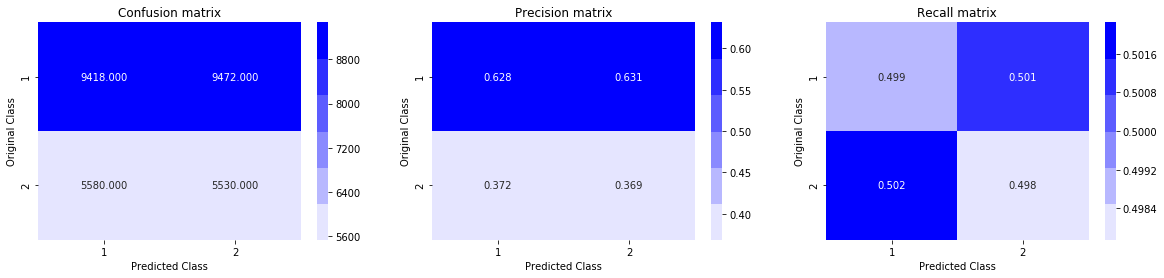

In [23]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

In [ ]:
train_new_df
test_new_df
y_train_true
y_test_true

In [55]:
y_test_true = np.array(y_test_true)

In [57]:
y_test_true = y_test_true.reshape(-1,1)
y_test_true.shape

(29999, 1)

For values of alpha =  1e-05 The log loss is: 0.45358342882930525
For values of alpha =  0.0001 The log loss is: 0.44684640066468745
For values of alpha =  0.001 The log loss is: 0.44998181474648646
For values of alpha =  0.01 The log loss is: 0.43474144599851366
For values of alpha =  0.1 The log loss is: 0.4502841513389442
For values of alpha =  1 The log loss is: 0.4913442444975526
For values of alpha =  10 The log loss is: 0.5444307834817205


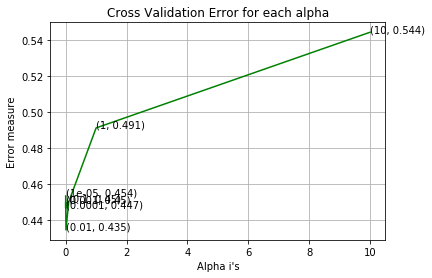

For values of best alpha =  0.01 The train log loss is: 0.4326648630804233
For values of best alpha =  0.01 The test log loss is: 0.43474144599851366
Total number of data points : 29999


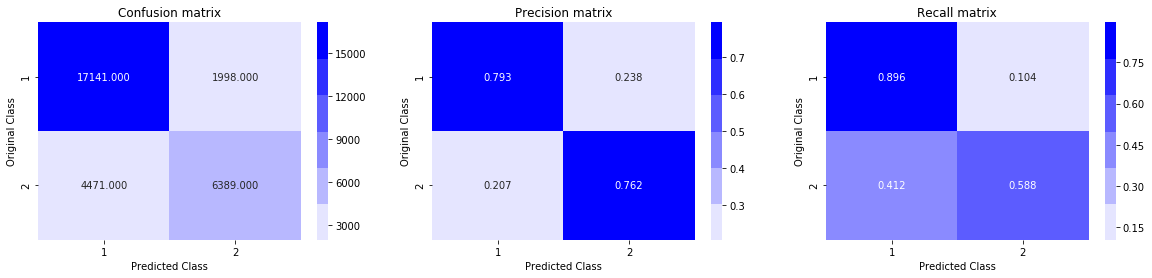

In [59]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_new_df, y_train_true)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_new_df, y_train_true)
    predict_y = sig_clf.predict_proba(test_new_df)
    log_error_array.append(log_loss(y_test_true, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_true, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_new_df, y_train_true)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_new_df, y_train_true)

predict_y = sig_clf.predict_proba(train_new_df)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_true, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_new_df)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_true, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_true, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4779613613943739
For values of alpha =  0.0001 The log loss is: 0.4860553337041227
For values of alpha =  0.001 The log loss is: 0.4999406972779974
For values of alpha =  0.01 The log loss is: 0.5091822652884789
For values of alpha =  0.1 The log loss is: 0.4983324979899143
For values of alpha =  1 The log loss is: 0.5936896165490428
For values of alpha =  10 The log loss is: 0.6433535731885073


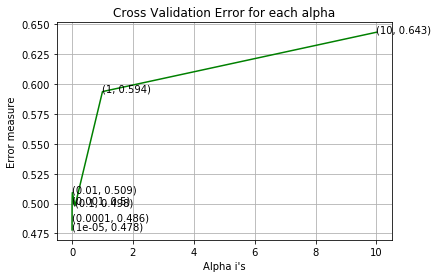

For values of best alpha =  1e-05 The train log loss is: 0.4735816086046346
For values of best alpha =  1e-05 The test log loss is: 0.4779613613943739
Total number of data points : 29999


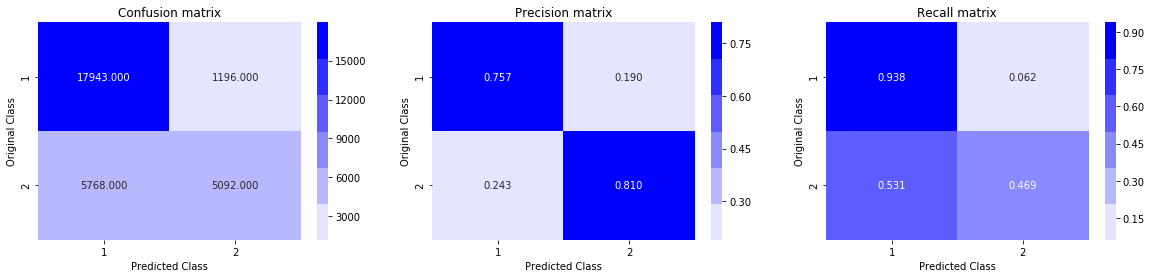

In [61]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# train_new_df
# test_new_df
# y_train_true
# y_test_true


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(train_new_df, y_train_true)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_new_df, y_train_true)
    predict_y = sig_clf.predict_proba(test_new_df)
    log_error_array.append(log_loss(y_test_true, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_true, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(train_new_df, y_train_true)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_new_df, y_train_true)

predict_y = sig_clf.predict_proba(train_new_df)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_true, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_new_df)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_true, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_true, predicted_y)

<h2> 4.6 XGBoost </h2>

### Hyperparameter tuning

In [35]:
from xgboost import XGBClassifier
from datetime import datetime
start = datetime.now()
clf = XGBClassifier(n_jobs=4, random_state=42, objective='binary:logistic')

# 'tree_method': ['gpu_hist'] add in params for gpu training
params={'colsample_bylevel':[0.4, 0.6, 0.8],
        'subsample':[0.4,0.6,0.8],
        'learning_rate':[0.1,0.2,0.3],
        'n_estimators':[int(x) for x in np.linspace(start=100, stop=500, num=100)],
        'max_depth':[6,8,12,16],
        'gamma':[0.1,0.2,0.3]}

oldparams = {}
oldparams['eval_metric'] = 'logloss'


model = RandomizedSearchCV(estimator=clf, param_distributions=params, n_iter=5, 
                           n_jobs=4,verbose=1, fit_params=oldparams, cv=3, scoring='neg_log_loss', refit=False)

X_train = np.asmatrix(X_train)


model.fit(X_train, y_train)
print('-'*50)
print('end time', datetime.now() - start)

/home/karthikmgcp/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


--------------------------------------------------
end time 1:42:29.794605


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 102.5min finished


In [38]:
model.best_params_

{'colsample_bylevel': 0.4,
 'gamma': 0.3,
 'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 334,
 'subsample': 0.6}

In [41]:
model.best_score_

-0.33472719430544884

### applying learned values

In [63]:
# train_new_df
# test_new_df
# y_train_true
# y_test_true

from xgboost import XGBClassifier
from datetime import datetime
start = datetime.now()

clf = XGBClassifier(colsample_bylevel=0.4, gamma=0.3, learning_rate=0.1 
                    ,max_depth=6, n_estimators=334, subsample=0.6, n_jobs=4, random_state=42, objective='binary:logistic')

log_error_array=[]
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_new_df, y_train_true)
predict_y = sig_clf.predict_proba(test_new_df)
log_error_array.append(log_loss(y_test_true, predict_y, eps=1e-15))
print("The log loss is:",log_loss(y_test_true, predict_y, eps=1e-15))

print('end time', datetime.now() - start)

The log loss is: 0.37070713571727565
end time 0:16:42.398043


Total number of data points : 29999


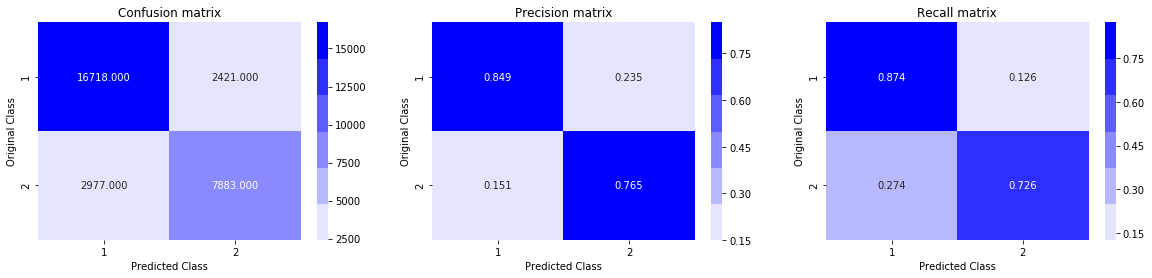

In [66]:
real_predict_y = np.argmax(predict_y, axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_true, real_predict_y)

### Conclusion

### How did I solve?

In [67]:
from prettytable import PrettyTable

In [68]:
x = PrettyTable()

In [69]:
x.field_names = ['algorithm', 'logloss']

In [73]:
x.add_row(['xgboost', '0.37'])

In [78]:
x.sortby = "logloss"
x.reversesort = True

In [79]:
print(x)

+----------------------+---------+
|      algorithm       | logloss |
+----------------------+---------+
|        random        |   0.88  |
|      linear svm      |   0.46  |
| logisitic regression |   0.44  |
|       xgboost        |   0.34  |
+----------------------+---------+
